In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

plt.style.use('ggplot')

In [9]:
df = pd.read_excel("final_data.xls", parse_dates=["Years"])
df["Years"] = df['Years'].dt.year
df.set_index('Years', inplace=True)

In [40]:
df.head(4)

,Bottom_50p,Unemployment,GDP_per_change
Years,,,
1948,17.10,3.750000,7.93894
1949,16.72,6.050000,-3.47367
1950,17.32,5.208333,18.22361
1951,18.27,3.283333,11.32476


In [11]:
df.shape

(72, 3)

In [12]:
df.describe()

,Bottom_50p,Unemployment,GDP_per_change
count,72.000000,72.000000,72.000000
mean,16.710278,5.734097,6.396404
std,2.326287,1.618131,3.425614
min,12.820000,2.925000,-3.473670
25%,14.700000,4.583333,4.402233
50%,17.130000,5.579167,6.197855
75%,18.777500,6.843750,8.060033
max,20.240000,9.708333,18.223610


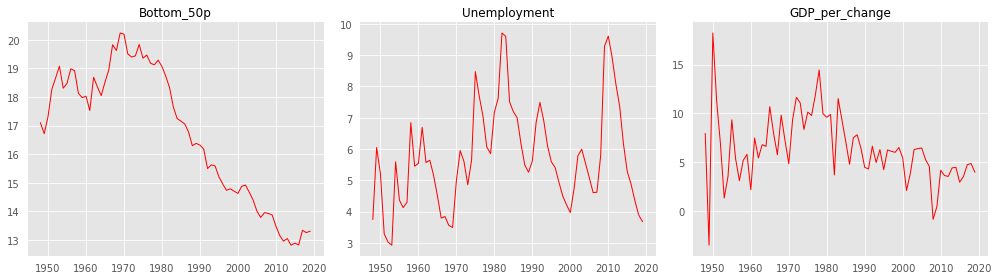

In [13]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i], fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout();

In [14]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Bottom_50p_x,Unemployment_x,GDP_per_change_x
Bottom_50p_y,1.000,0.0064,0.0
Unemployment_y,0.019,1.0000,0.0
GDP_per_change_y,0.000,0.0002,1.0


In [15]:
df.tail()

,Bottom_50p,Unemployment,GDP_per_change
Years,,,
2015,12.89,5.275000,2.96299
2016,12.83,4.875000,3.55723
2017,13.34,4.350000,4.75702
2018,13.26,3.891667,4.87457
2019,13.31,3.680000,4.00548


In [16]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (68, 3)
print(df_test.shape)  # (4, 3)

(68, 3)
(4, 3)


In [17]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df.columns[i]))

Bottom_50p - Series is not Stationary
Unemployment - Series is Stationary
GDP_per_change - Series is Stationary


In [18]:
df_differenced = df_train.diff().dropna()

In [19]:
for i in range(len(df_differenced.columns)):
  result = adfuller(df_differenced[df_differenced.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df_differenced.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df_differenced.columns[i]))

Bottom_50p - Series is Stationary
Unemployment - Series is Stationary
GDP_per_change - Series is Stationary


In [20]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -0.011827582684564297
BIC :  0.3862914613202403
FPE :  0.9886831475256405
HQIC:  0.14548817370377054 

Lag Order = 2
AIC :  -0.7423422143679234
BIC :  -0.03984786563240994
FPE :  0.47719658977182494
HQIC:  -0.46516315890813653 

Lag Order = 3
AIC :  -0.8837620695401469
BIC :  0.12821437578469919
FPE :  0.4164374829422708
HQIC:  -0.48509343018415585 

Lag Order = 4
AIC :  -0.7726654388899679
BIC :  0.5540370107809811
FPE :  0.4701847048616593
HQIC:  -0.2508668807078185 

Lag Order = 5
AIC :  -1.062928416384672
BIC :  0.5838853010695924
FPE :  0.3580390491981238
HQIC:  -0.4163478032565924 

Lag Order = 6
AIC :  -0.8840629600684002
BIC :  1.0883929457984642
FPE :  0.4405002042566592
HQIC:  -0.11103900528456379 

Lag Order = 7
AIC :  -0.8469043541633923
BIC :  1.4568746642809183
FPE :  0.477350101669978
HQIC:  0.05423026798030328 

Lag Order = 8
AIC :  -1.008060350820064
BIC :  1.6328770778736472
FPE :  0.43297971073841773
HQIC:  0.022854662380645152 

Lag Order = 9
AI

In [21]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, May, 2021
Time:                     00:16:10
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.583885
Nobs:                     62.0000    HQIC:                 -0.416348
Log likelihood:          -182.972    FPE:                   0.358039
AIC:                     -1.06293    Det(Omega_mle):        0.179813
--------------------------------------------------------------------
Results for equation Bottom_50p
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.061279         0.039965           -1.533           0.125
L1.Bottom_50p             0.161752         0.139060            1.163           0.245
L1.Unemployment           0.099785     

In [22]:
df.tail()

,Bottom_50p,Unemployment,GDP_per_change
Years,,,
2015,12.89,5.275000,2.96299
2016,12.83,4.875000,3.55723
2017,13.34,4.350000,4.75702
2018,13.26,3.891667,4.87457
2019,13.31,3.680000,4.00548


In [23]:
import statsmodels.api as sm
import sklearn.metrics as skm
estVAR = sm.tsa.VAR(df_differenced).fit(5)
skm.r2_score(estVAR.fittedvalues['Bottom_50p']+estVAR.resid['Bottom_50p'],
  estVAR.fittedvalues['Bottom_50p'])

y1 = estVAR.fittedvalues['Bottom_50p']+estVAR.resid['Bottom_50p']
r_squared = 1 - np.sum(estVAR.resid['Bottom_50p'].values**2)/np.sum((y1.values-y1.mean())**2)
adjusted_r_squared_b50p = 1 - (1-r_squared)*(len(y1)-1)/(len(y1)-df_differenced.shape[1]-1)

y2 = estVAR.fittedvalues['Unemployment']+estVAR.resid['Unemployment']
r_squared = 1 - np.sum(estVAR.resid['Unemployment'].values**2)/np.sum((y2.values-y2.mean())**2)
adjusted_r_squared_unemp = 1 - (1-r_squared)*(len(y2)-1)/(len(y2)-df_differenced.shape[1]-1)

y3 = estVAR.fittedvalues['GDP_per_change']+estVAR.resid['GDP_per_change']
r_squared = 1 - np.sum(estVAR.resid['GDP_per_change'].values**2)/np.sum((y3.values-y3.mean())**2)
adjusted_r_squared_gdp = 1 - (1-r_squared)*(len(y3)-1)/(len(y3)-df_differenced.shape[1]-1)

In [24]:
print('Bottom 50p R-squared:', round(adjusted_r_squared_b50p, 2))
print('Unemployment R-squared:', round(adjusted_r_squared_unemp, 2))
print('GDP per change R-squared:', round(adjusted_r_squared_gdp,2))

Bottom 50p R-squared: 0.52
Unemployment R-squared: 0.54
GDP per change R-squared: 0.49


In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Bottom_50p : 2.03
Unemployment : 2.06
GDP_per_change : 2.12


A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation.

In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 5

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[-0.33      , -0.675     , -0.54379   ],
       [-0.2       , -0.85833333, -0.08527   ],
       [ 0.09      , -0.71666667,  0.8671    ],
       [-0.23      , -1.2       ,  0.06108   ],
       [ 0.07      , -0.88333333, -1.5255    ]])

In [27]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,Bottom_50p_1d,Unemployment_1d,GDP_per_change_1d
Years,,,
2016,-0.115924,0.376571,-0.498461
2017,0.133859,0.532775,-1.317189
2018,-0.094896,0.814068,0.477718
2019,-0.210611,0.243477,0.517822


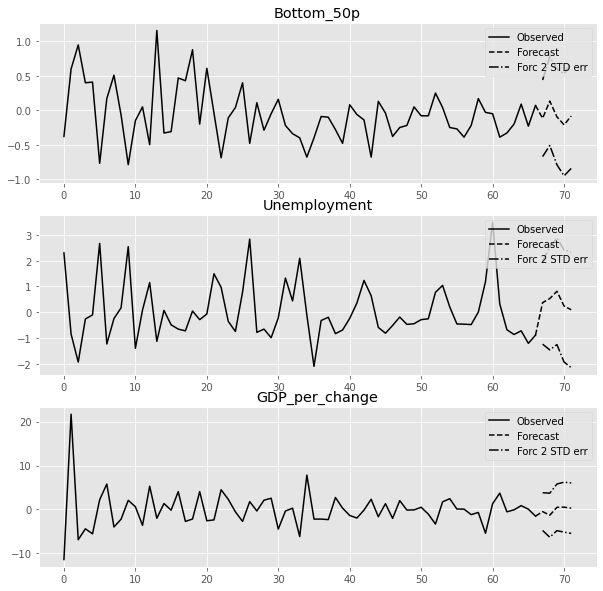

In [29]:
ax = model_fitted.plot_forecast(5, alpha=0.05, plot_stderr=True)

In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [31]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results[["Bottom_50p_forecast", "Unemployment_forecast", "GDP_per_change_forecast"]]

,Bottom_50p_forecast,Unemployment_forecast,GDP_per_change_forecast
Years,,,
2016,12.774076,5.651571,2.464529
2017,12.907935,6.184346,1.147340
2018,12.813039,6.998413,1.625058
2019,12.602428,7.241891,2.142880


In [32]:
df.tail(4)

,Bottom_50p,Unemployment,GDP_per_change
Years,,,
2016,12.83,4.875000,3.55723
2017,13.34,4.350000,4.75702
2018,13.26,3.891667,4.87457
2019,13.31,3.680000,4.00548


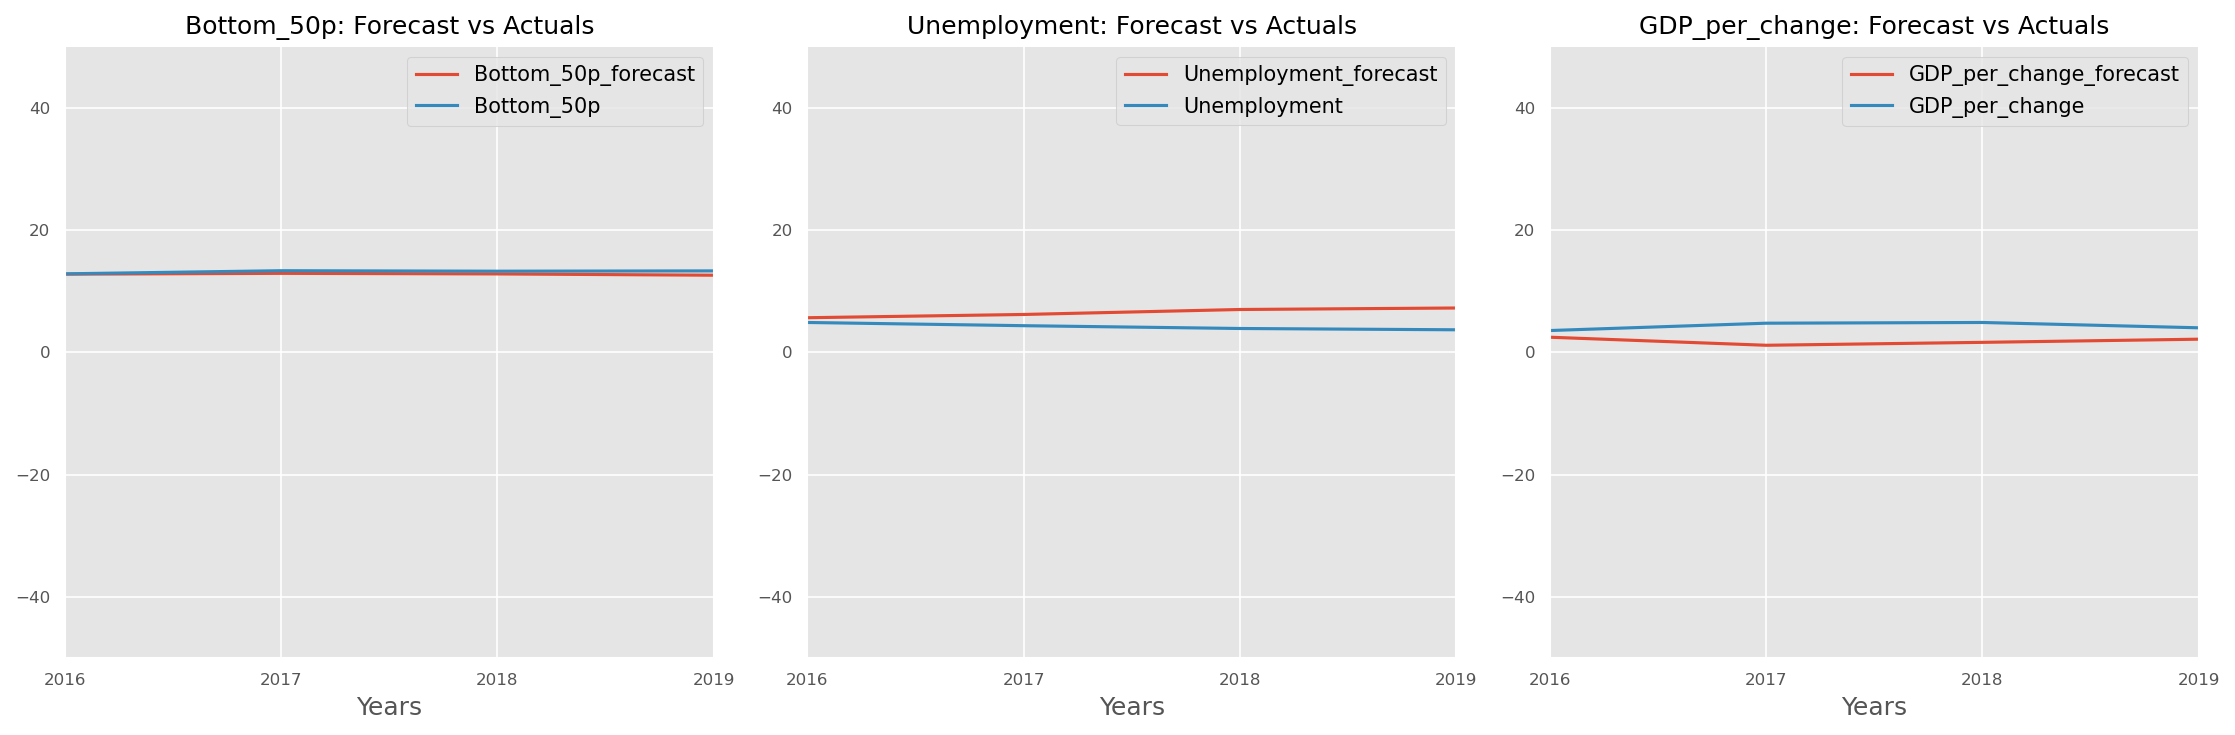

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=150, figsize=(15,5))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)
    ax.set_ylim((-50,50))
plt.tight_layout();

In [34]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100 # MAPE
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual) *100  # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)*100            # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Bottom 50 percent')
accuracy_prod = forecast_accuracy(df_results['Bottom_50p_forecast'].values, df_test['Bottom_50p'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
    
print('\nForecast Accuracy of: Unemployment Rate')
accuracy_prod = forecast_accuracy(df_results['Unemployment_forecast'].values, df_test['Unemployment'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: GDP percentage change')
accuracy_prod = forecast_accuracy(df_results['GDP_per_change_forecast'].values, df_test['GDP_per_change'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Bottom 50 percent
mape :  3.0904
me :  -0.4106
mae :  0.4106
mpe :  -3.0904
rmse :  0.4718
corr :  0.0242
minmax :  -95.9096

Forecast Accuracy of: Unemployment Rate
mape :  58.6799
me :  2.3199
mae :  2.3199
mpe :  58.6799
rmse :  2.5645
corr :  -0.9928
minmax :  -64.7553

Forecast Accuracy of: GDP percentage change
mape :  54.9407
me :  -2.4536
mae :  2.4536
mpe :  -54.9407
rmse :  2.6576
corr :  -0.9117
minmax :  -44.0593


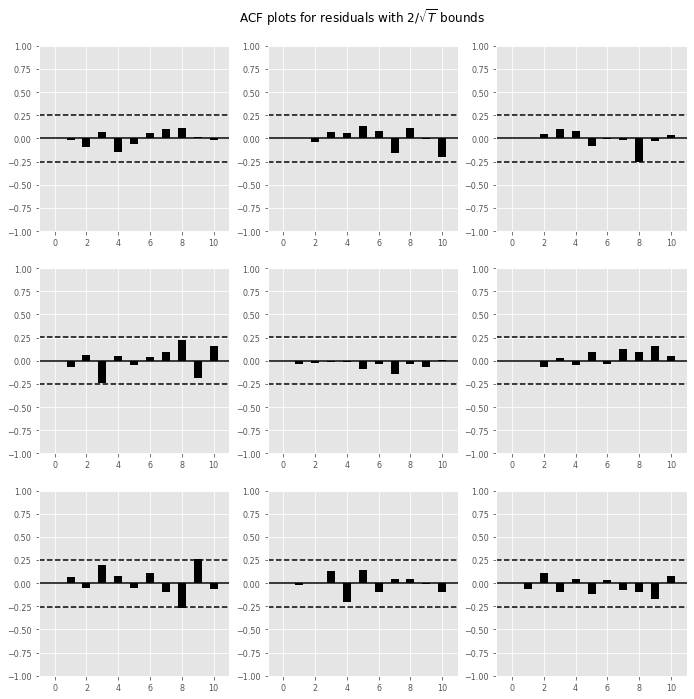

In [28]:
model_fitted.plot_acorr();

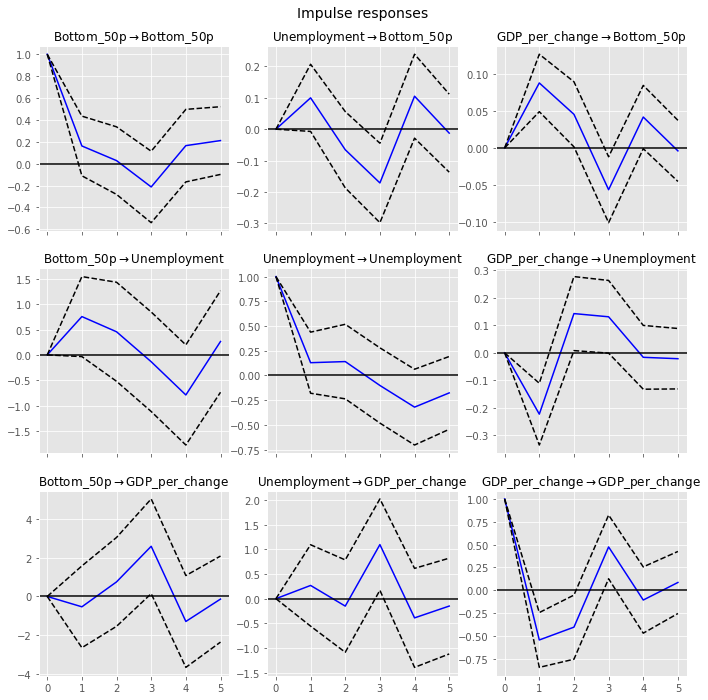

In [37]:
irf = model_fitted.irf(5)
irf.plot(orth=False);

In [38]:
a = model_fitted.test_normality()
a.summary()

Test statistic,Critical value,p-value,df
7.082,12.59,0.313,6


While this assumption is not required for parameter estimates to be consistent or asymptotically normal, results are generally more reliable in finite samples when residuals are Gaussian white noise.